# Car Seats
- A simulated data set containing sales of child car seats at 400 different stores.
- There are 400 rows.
- There are 11 variables:
    - Sales: Unit sales (in thousands) at each location
    - CompPrice: Price charged by competitor at each location
    - Income: Community income level (in thousands of dollars)
    - Advertising: Local advertising budget for company at each location (in thousands of dollars)
    - Population: Population size in region (in thousands)
    - Price: Price company charges for car seats at each site ("site" refers to an individual store location)
    - ShelveLoc: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
        - Bad: Indicates a poor shelving location, which might result in lower visibility and potentially fewer sales.
    - Age: Average age of the local population
    - Education: Education level at each location
    - Urban: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
    - US: A factor with levels No and Yes to indicate whether the store is in the US or not

# Load Packages and Data

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree, export_text)
from sklearn.metrics import accuracy_score, log_loss
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
Carseats = load_data('Carseats')
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
Carseats.describe().round(1)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,7.5,125.0,68.7,6.6,264.8,115.8,53.3,13.9
std,2.8,15.3,28.0,6.7,147.4,23.7,16.2,2.6
min,0.0,77.0,21.0,0.0,10.0,24.0,25.0,10.0
25%,5.4,115.0,42.8,0.0,139.0,100.0,39.8,12.0
50%,7.5,125.0,69.0,5.0,272.0,117.0,54.5,14.0
75%,9.3,135.0,91.0,12.0,398.5,131.0,66.0,16.0
max,16.3,175.0,120.0,29.0,509.0,191.0,80.0,18.0


# Fitting Classification Trees
## Grow a tree

- We create a binary variable `High`, which indicates whether sales are larger than 8 or not.

In [4]:
#High = Carseats.Sales > 8
High = np.where(Carseats.Sales > 8, "Yes", "No")

- We create a design matrix that includes all the variables except `Sales`.
- We need to convert the design matrix to `ndarray` for the `DecisionTreeClassifier` function.
- We save column names for later use.

In [5]:
Design_Matrix = MS(Carseats.columns.drop('Sales'), intercept=False).fit_transform(Carseats)
feature_names = Design_Matrix.columns
X = np.asarray(Design_Matrix)

- Arguments for the `DecisionTreeClassifier` function:
    - `criterion`: The function to measure the quality of a split. The default value is `gini`.
    - `max_depth`: The maximum depth of the tree. The default value is `None`.
    - `min_samples_split`: The minimum number of samples required to split an internal node. The default value is `2`.
    - `min_samples_leaf`: The minimum number of samples required to be at a leaf node. The default value is `1`.
    - `random_state`: The seed of the pseudo random number generator to use when shuffling the data. The default value is `None`.

In [10]:
# Fit a decision tree
TRE_clas = DTC(criterion='entropy', max_depth=3, random_state=0)        
TRE_clas.fit(X, High);

- The book describes a natural way to handle qualitative features in decision trees by partitioning levels into two groups. However, sklearn's decision tree implementation treats one-hot-encoded levels as separate variables instead.
- We check the accuracy of the model.


In [11]:
accuracy_score(High, TRE_clas.predict(X))

0.79

- With default arguments, the training error rate is 21%. 
- For classification trees, we can use `log_loss()` to access the deviance value.
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the m-th terminal node that belong to the k-th class.
- This is closely related to the *entropy* defined in the book.
- A small deviance suggests that the tree fits the training data well.

In [12]:
resid_dev = np.sum(log_loss(High, TRE_clas.predict_proba(X)))
resid_dev

0.4710647062649358

- We plot the tree.

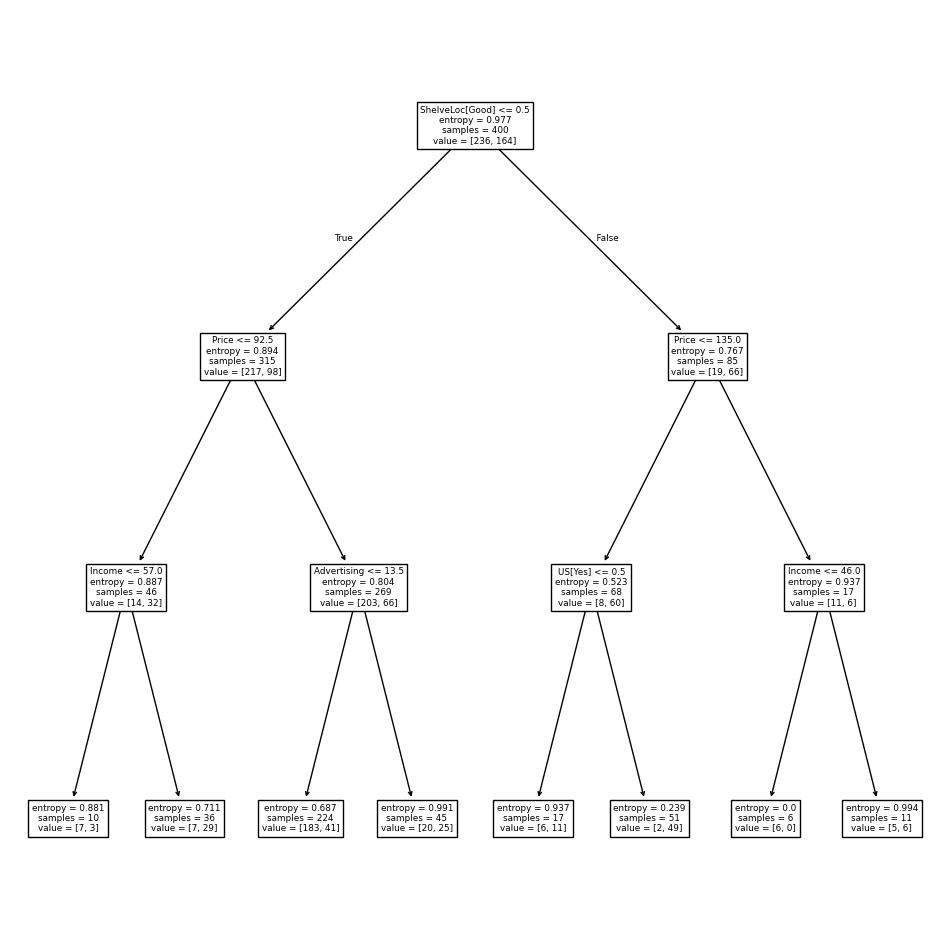

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
plot_tree(TRE_clas, feature_names=feature_names, ax=ax);

- The key indicator of `Sales` is `ShelveLoc`. 
- We use `export_text()` to print the tree in text format.
- We use `show_weights=True` to see the number of observations in each node.

In [19]:
print(export_text(TRE_clas, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



- We split the data into training and validatation sets (200 elements).
- We fit a tree to the training data and evaluate its performance on the validation data.


In [21]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(TRE_clas, X, High, cv=validation)
results['test_score']

array([0.685])

- This procedure yields a correct prediction for 68.5% of the observations in the validation set.

## Prune a tree
- We split the data into training and test sets (50%).
- We use cross-validation to prune the tree on the training data.
- Then we evaluate the pruned tree on the test data.

In [22]:
X_train, X_test, High_train, High_test = skm.train_test_split(
    X, High, test_size=0.5, random_state=0)

- Fristly, we refit the tree to the training data without setting the maximum depth.

In [24]:
TRE_clas = DTC(criterion='entropy', random_state=0).fit(X_train, High_train)
accuracy_score(High_test, TRE_clas.predict(X_test))

0.735

- The result shows that the tree yieling a correct prediction for 73.5% of the observations in the test set.
- Next, we use `cost_complexity_pruning_path()` from `TRE_clas` to get the cost-complexity values.

In [25]:
ccp_path = TRE_clas.cost_complexity_pruning_path(X_train, High_train)
ccp_path

{'ccp_alphas': array([0.        , 0.01622556, 0.0171946 , 0.0180482 , 0.0180482 ,
        0.01991688, 0.02012073, 0.02070855, 0.02193427, 0.0219518 ,
        0.02220877, 0.02274806, 0.02417233, 0.02588672, 0.02714959,
        0.02735525, 0.02900052, 0.02906078, 0.03209543, 0.04499252,
        0.06236632, 0.10024835]),
 'impurities': array([0.        , 0.01622556, 0.05061477, 0.06866297, 0.08671117,
        0.12654492, 0.14666566, 0.16737421, 0.18930848, 0.21126028,
        0.25567782, 0.27842588, 0.32677055, 0.35265727, 0.43410604,
        0.54352706, 0.57252758, 0.65970991, 0.72390076, 0.8138858 ,
        0.87625212, 0.97650047])}

- The result is impurities and $\alpha$ values that we can optimize using cross-validation.
    - CCP alphas are the effective complexity parameters used to prune a decision tree. These numbers are listed from smallest to largest. Each alpha value corresponds to a different pruned version of the tree.
    - Impurities are the total impurities of the leaves in the decision tree after pruning with the corresponding ccp_alpha.
    - Cost complexity combines tree impurity with node count. 

In [27]:
# Set 10-fold cross-validation up
kfold = skm.KFold(10, random_state=1, shuffle=True)
# Run grid search
grid = skm.GridSearchCV(TRE_clas, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')
# Refit with the prunned tree
grid.fit(X_train, High_train)
# Show the trainning error rate
grid.best_score_

0.685

- We plot the pruned true.

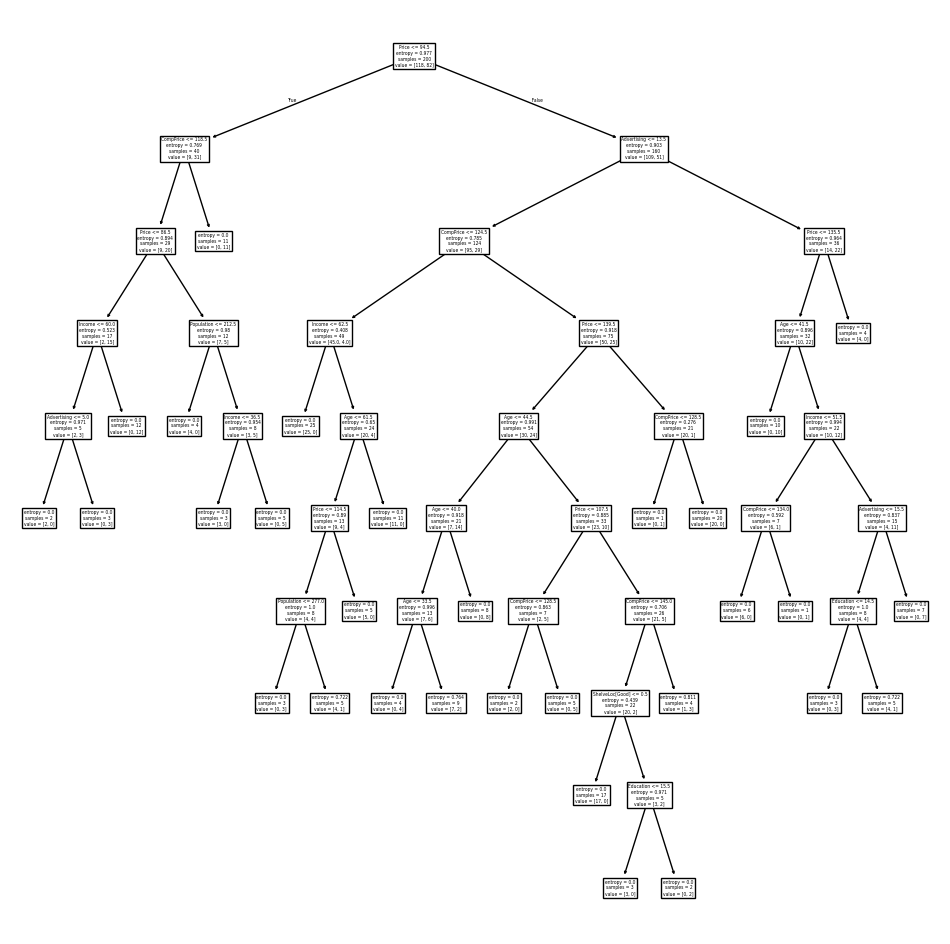

In [29]:
ax = plt.subplots(figsize=(12, 12))[1]
plot_tree(grid.best_estimator_, feature_names=feature_names, ax=ax);

- We can count the leaves.

In [30]:
grid.best_estimator_.tree_.n_leaves

30

- The 30-terminal node tree has the lowest cross-validation error rate at 68.5% accuracy. 
- We assess its performance on the test data set using the `predict()` function.

In [31]:
accuracy_score(High_test, grid.best_estimator_.predict(X_test))

0.72

In [32]:
# Show confusion table
confusion_table(grid.best_estimator_.predict(X_test), High_test)

Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


- Currently, 72.0% of test observations are correctly classified, slightly worse than the full tree with 35 leaves.
- Thus, cross-validation has not significantly improved results, pruning only 5 leaves at the cost of increased error.
- Results could vary with different random seeds, as cross-validation, while unbiased, has some variance.  

# Remake with Different Labels
- In the case above, we labeled "Yes" and "No". They will be encoded No=0 and Yes=1.
- We will label "High_Sales" and "Low_Sales". They will be encoded High_Sales=0 and Low_Sales=1.

In [51]:
High = np.where(Carseats.Sales > 8, "High_Sales", "Low_Sales")
X_train,X_test,High_train,High_test = skm.train_test_split(X,High,test_size=0.5,random_state=0)

- First, we refit the tree to the training data without setting the maximum depth.

In [52]:
TRE_clas = DTC(criterion='entropy', random_state=0)
TRE_clas.fit(X_train, High_train)
accuracy_score(High_test, TRE_clas.predict(X_test))

0.735

- The result is similar.
- We use `cost_complexity_pruning_path()` from `clf` to get the cost-complexity values.

In [53]:
ccp_path = TRE_clas.cost_complexity_pruning_path(X_train, High_train)

- We prune the tree using cross-validation.

In [54]:
# Set 10-fold cross-validation up
kfold = skm.KFold(10, random_state=1, shuffle=True)
# Run grid search
grid = skm.GridSearchCV(TRE_clas, {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, cv=kfold, scoring='accuracy')
# Refit with the prunned tree
grid.fit(X_train, High_train)
# Show the trainning error rate
grid.best_score_

0.6849999999999999

- We plot the pruned tree.

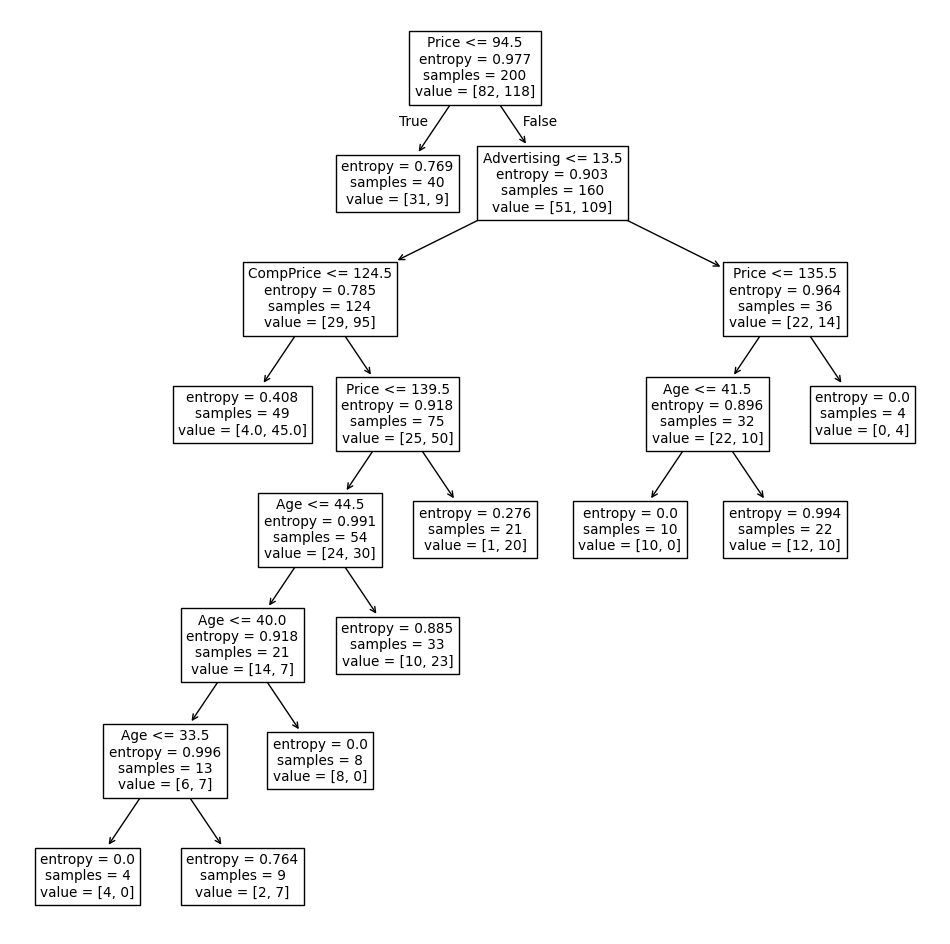

In [55]:
ax = plt.subplots(figsize=(12, 12))[1]
plot_tree(grid.best_estimator_, feature_names=feature_names, ax=ax);

In [56]:
# Count the number of leaves
grid.best_estimator_.tree_.n_leaves

10

In [57]:
# Access the test error rate
accuracy_score(High_test, grid.best_estimator_.predict(X_test))

0.68

In [58]:
# Show confusion table
confusion_table(grid.best_estimator_.predict(X_test), High_test)

Truth,High_Sales,Low_Sales
Predicted,,
High_Sales,38,20
Low_Sales,44,98
